In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la
from random import sample

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


import pandas as pd

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [2]:
# Loading Confusion Matrix

conf_mat = np.load('conf_mat_86_params.npy')
conf_mat = conf_mat[0:50,:,:,:]
conf_mat[49,:,:,4]

array([[1448.,   39.,    2.],
       [   5.,  508.,   13.],
       [   0.,   46.,  605.]])

In [3]:
# Normalising Matrices

def normalise_mat(C):
    C_n = C / C.astype(np.float).sum(axis=1, keepdims=True)
    # Correct, checked using: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    # Found at: https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
    
    return C_n

conf_mat_n = np.zeros((50,3,3,5))

for i in range (50):
    conf_mat_n[i,:,:,0] = normalise_mat(conf_mat[i,:,:,0])
    conf_mat_n[i,:,:,1] = normalise_mat(conf_mat[i,:,:,1])
    conf_mat_n[i,:,:,2] = normalise_mat(conf_mat[i,:,:,2])
    conf_mat_n[i,:,:,3] = normalise_mat(conf_mat[i,:,:,3])
    conf_mat_n[i,:,:,4] = normalise_mat(conf_mat[i,:,:,4])

In [4]:
# Calculating average confusion matrix

avg_conf = np.zeros((50,3,3))
avg_conf_train = np.zeros((50,3,3))
avg_conf_test = np.zeros((50,3,3))
std_conf = np.zeros((50,3,3))

for i in range (50): 
    avg_conf[i,:,:] = np.mean( np.array([ conf_mat_n[i,:,:,0],conf_mat_n[i,:,:,1],conf_mat_n[i,:,:,2], conf_mat_n[i,:,:,3], conf_mat_n[i,:,:,4] ]), axis=0 )
    std_conf[i,:,:] = np.std(np.array([ conf_mat_n[i,:,:,0],conf_mat_n[i,:,:,1],conf_mat_n[i,:,:,2], conf_mat_n[i,:,:,3], conf_mat_n[i,:,:,4] ]), axis=0 )
    avg_conf_train[i,:,:] = np.mean( np.array([ conf_mat_n[i,:,:,0],conf_mat_n[i,:,:,1],conf_mat_n[i,:,:,2]]), axis=0 )
    avg_conf_test[i,:,:] = np.mean( np.array([conf_mat_n[i,:,:,3], conf_mat_n[i,:,:,4] ]), axis=0 )

In [5]:
# Total Average

summed = np.zeros((3,3))
sum_test = np.zeros((3,3))
sum_train = np.zeros((3,3))

for i in range (50): 
    summed = summed + avg_conf[i,:,:]
    sum_test = sum_test + avg_conf[i,:,:]
    sum_train = sum_train + avg_conf[i,:,:]
    
avg_conf_TOT = summed/50
avg_conf_TOT_test = sum_test/50
avg_conf_TOT_train = sum_train/50

print(avg_conf_TOT)

[[9.91770763e-01 7.88856327e-03 3.40674091e-04]
 [3.70501951e-03 9.85268727e-01 1.10262537e-02]
 [8.13275682e-04 3.50698245e-02 9.64116900e-01]]


In [6]:
# Calculating accuracy 

acc = np.zeros((50))
acc_test = np.zeros((50))
acc_train = np.zeros((50))

for i in range (50):
    acc[i] = np.sum(np.diag(avg_conf[i,:,:]))/np.sum(np.sum(avg_conf[i,:,:]))
    acc_test[i] = np.sum(np.diag(avg_conf_test[i,:,:]))/np.sum(np.sum(avg_conf_test[i,:,:]))
    acc_train[i] = np.sum(np.diag(avg_conf_train[i,:,:]))/np.sum(np.sum(avg_conf_train[i,:,:]))

In [7]:
acc

array([0.98333714, 0.97669734, 0.98233714, 0.97686606, 0.98245587,
       0.98310998, 0.98206624, 0.97636482, 0.98284919, 0.98208549,
       0.98291901, 0.97630452, 0.97712607, 0.98109603, 0.98239494,
       0.98121143, 0.98248359, 0.97602281, 0.982635  , 0.98322283,
       0.97545334, 0.98231659, 0.98224965, 0.98296903, 0.97620274,
       0.98311283, 0.98292194, 0.98297517, 0.97704118, 0.98334815,
       0.98163353, 0.97610754, 0.98237199, 0.97611338, 0.98114612,
       0.9759604 , 0.98326122, 0.9831218 , 0.98293012, 0.98215792,
       0.97543321, 0.97633329, 0.97655542, 0.97619437, 0.98158729,
       0.9764204 , 0.98297215, 0.9821    , 0.982655  , 0.98204187])

In [8]:
# Total Average Accuracy

acc_avg = np.average(acc)
acc_avg_test = np.average(acc_test)
acc_avg_train = np.average(acc_train)

print('All:', acc_avg)
print('Test:', acc_avg_test)
print('Train:', acc_avg_train)

All: 0.9803854630908382
Test: 0.9582421202872752
Train: 0.995147691626547


In [9]:
std_acc = np.std(acc)
std_acc_test = np.std(acc_test)
std_acc_train = np.std(acc_train)

print('All:', std_acc)
print('Test:', std_acc_test)
print('Train:', std_acc_train)

All: 0.002984422257795942
Test: 0.0011886267552251538
Train: 0.00462484420238289


In [10]:
# Getting indexes of accuracies 

ind = np.argsort(acc)
print(ind)

[40 20 35 17 31 33 43 24 11 41  7 45 42  1  3 28 12 13 34 15 44 30 49  6
  9 47 39 22 21  2 32 14  4 16 18 48  8 10 26 38 23 46 27  5 25 37 19 36
  0 29]


In [11]:
ind.shape
ind[23]

6

In [12]:
# Importing Images

def load_res(file_name):
    # Loading in Image

    img_nifti = nib.load(file_name)

    img =img_nifti.dataobj[:,:,:,:,:]
    
    classif = img[:,:,:,0,0:50]
    segment = img[:,:,:,1:4,0:50]

    return classif, segment

In [13]:
class_S1, seg_S1 = load_res('param_86_rf_S1.nii')
class_S2, seg_S2 = load_res('param_86_rf_S2.nii')
class_S3, seg_S3 = load_res('param_86_rf_S3.nii')
class_S4, seg_S4 = load_res('param_86_rf_S4.nii')
class_S5, seg_S5 = load_res('param_86_rf_S5.nii')

In [14]:
# Checking Shape

print('class shape: ', np.shape(class_S1))
print('seg shape: ', np.shape(seg_S1))

class shape:  (77, 92, 56, 50)
seg shape:  (77, 92, 56, 3, 50)


In [15]:
# Combining into a List
class_list = [class_S1, class_S2, class_S3, class_S4, class_S5] 
seg_list = [seg_S1, seg_S2, seg_S3, seg_S4, seg_S5 ]

In [16]:
class_S1.shape

(77, 92, 56, 50)

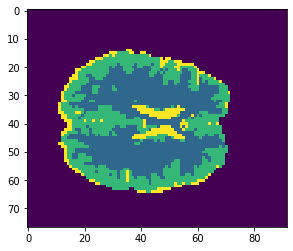

In [17]:
plt.imshow(class_S1[:,:,33,0])

In [44]:
# Saving Lists
np.save('class_list_all.npy', class_list, allow_pickle = True)
np.save('seg_list_all.npy', seg_list, allow_pickle = True)

MemoryError: 

In [18]:
# Plotting everything for slice 33

def plotting_all_results(class_S, seg_S, z, t, n=5):
    fig = plt.gcf()
    fig.set_size_inches(20,20)

    for i in range (0,n):  
        plt.subplot(n, 4, 1+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(class_S[i][:,:,z,t])
        plt.subplot(n, 4, 2+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(seg_S[i][:,:,z,0,t])
        plt.subplot(n, 4, 3+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(seg_S[i][:,:,z,1,t])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n, 4, 4+4*i)
        plt.imshow(seg_S[i][:,:,z,2,t])
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.05)

In [19]:
# Plotting differences for slice 33

def plotting_diffs(class_A, class_B, seg_A, seg_B, z, t, n=5):
    fig = plt.gcf()
    fig.set_size_inches(20,20)

    for i in range (0,n):  
        plt.subplot(n, 4, 1+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(class_A[i][:,:,z,t]-class_B[i][:,:,z]))
        plt.subplot(n, 4, 2+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(seg_A[i][:,:,z,0,t]-seg_B[i][:,:,z,0]))
        plt.subplot(n, 4, 3+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.abs(seg_A[i][:,:,z,1,t]-seg_B[i][:,:,z,1]))
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n, 4, 4+4*i)
        plt.imshow(np.abs(seg_A[i][:,:,z,2,t]-seg_B[i][:,:,z,2]))
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.05)
    

In [20]:
# Loading in Lists

class_combined = np.load('class_list_combined.npy', allow_pickle = True)
seg_combined = np.load('seg_list_combined.npy', allow_pickle = True)

class_all = np.load('class_list_all.npy', allow_pickle = True)
seg_all = np.load('seg_list_all.npy', allow_pickle = True)

EOFError: Ran out of input

In [ ]:
# Comparing the Best Trial 

plotting_all_results(class_list, seg_list, 33, 29)

In [ ]:
plotting_diffs(class_list, class_combined, seg_list, seg_combined, 33, 29)

In [53]:
# Comparing Worst Trial

plotting_all_results(class_list, seg_list, 33, 40)

In [54]:
plotting_diffs(class_list, class_combined, seg_list, seg_combined, 33, 40)

In [55]:
# Comparing Worst against All

plotting_diffs( class_list, class_all, seg_list, seg_all,  33, 40)

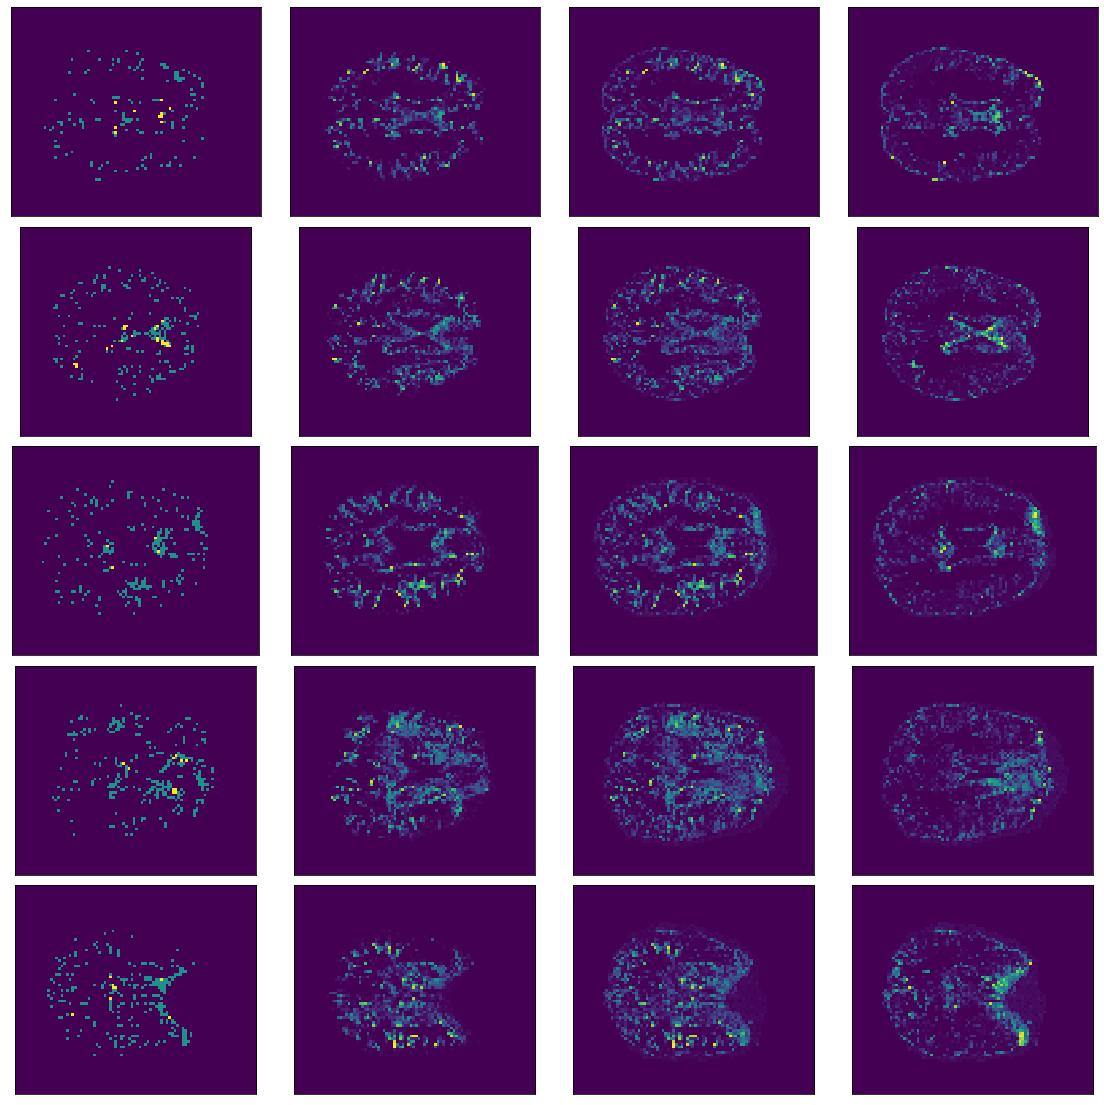

In [56]:
# Comparing Mid against All

plotting_diffs( class_list, class_all, seg_list, seg_all,  33, 6)

In [28]:
import matplotlib.gridspec as gridspec

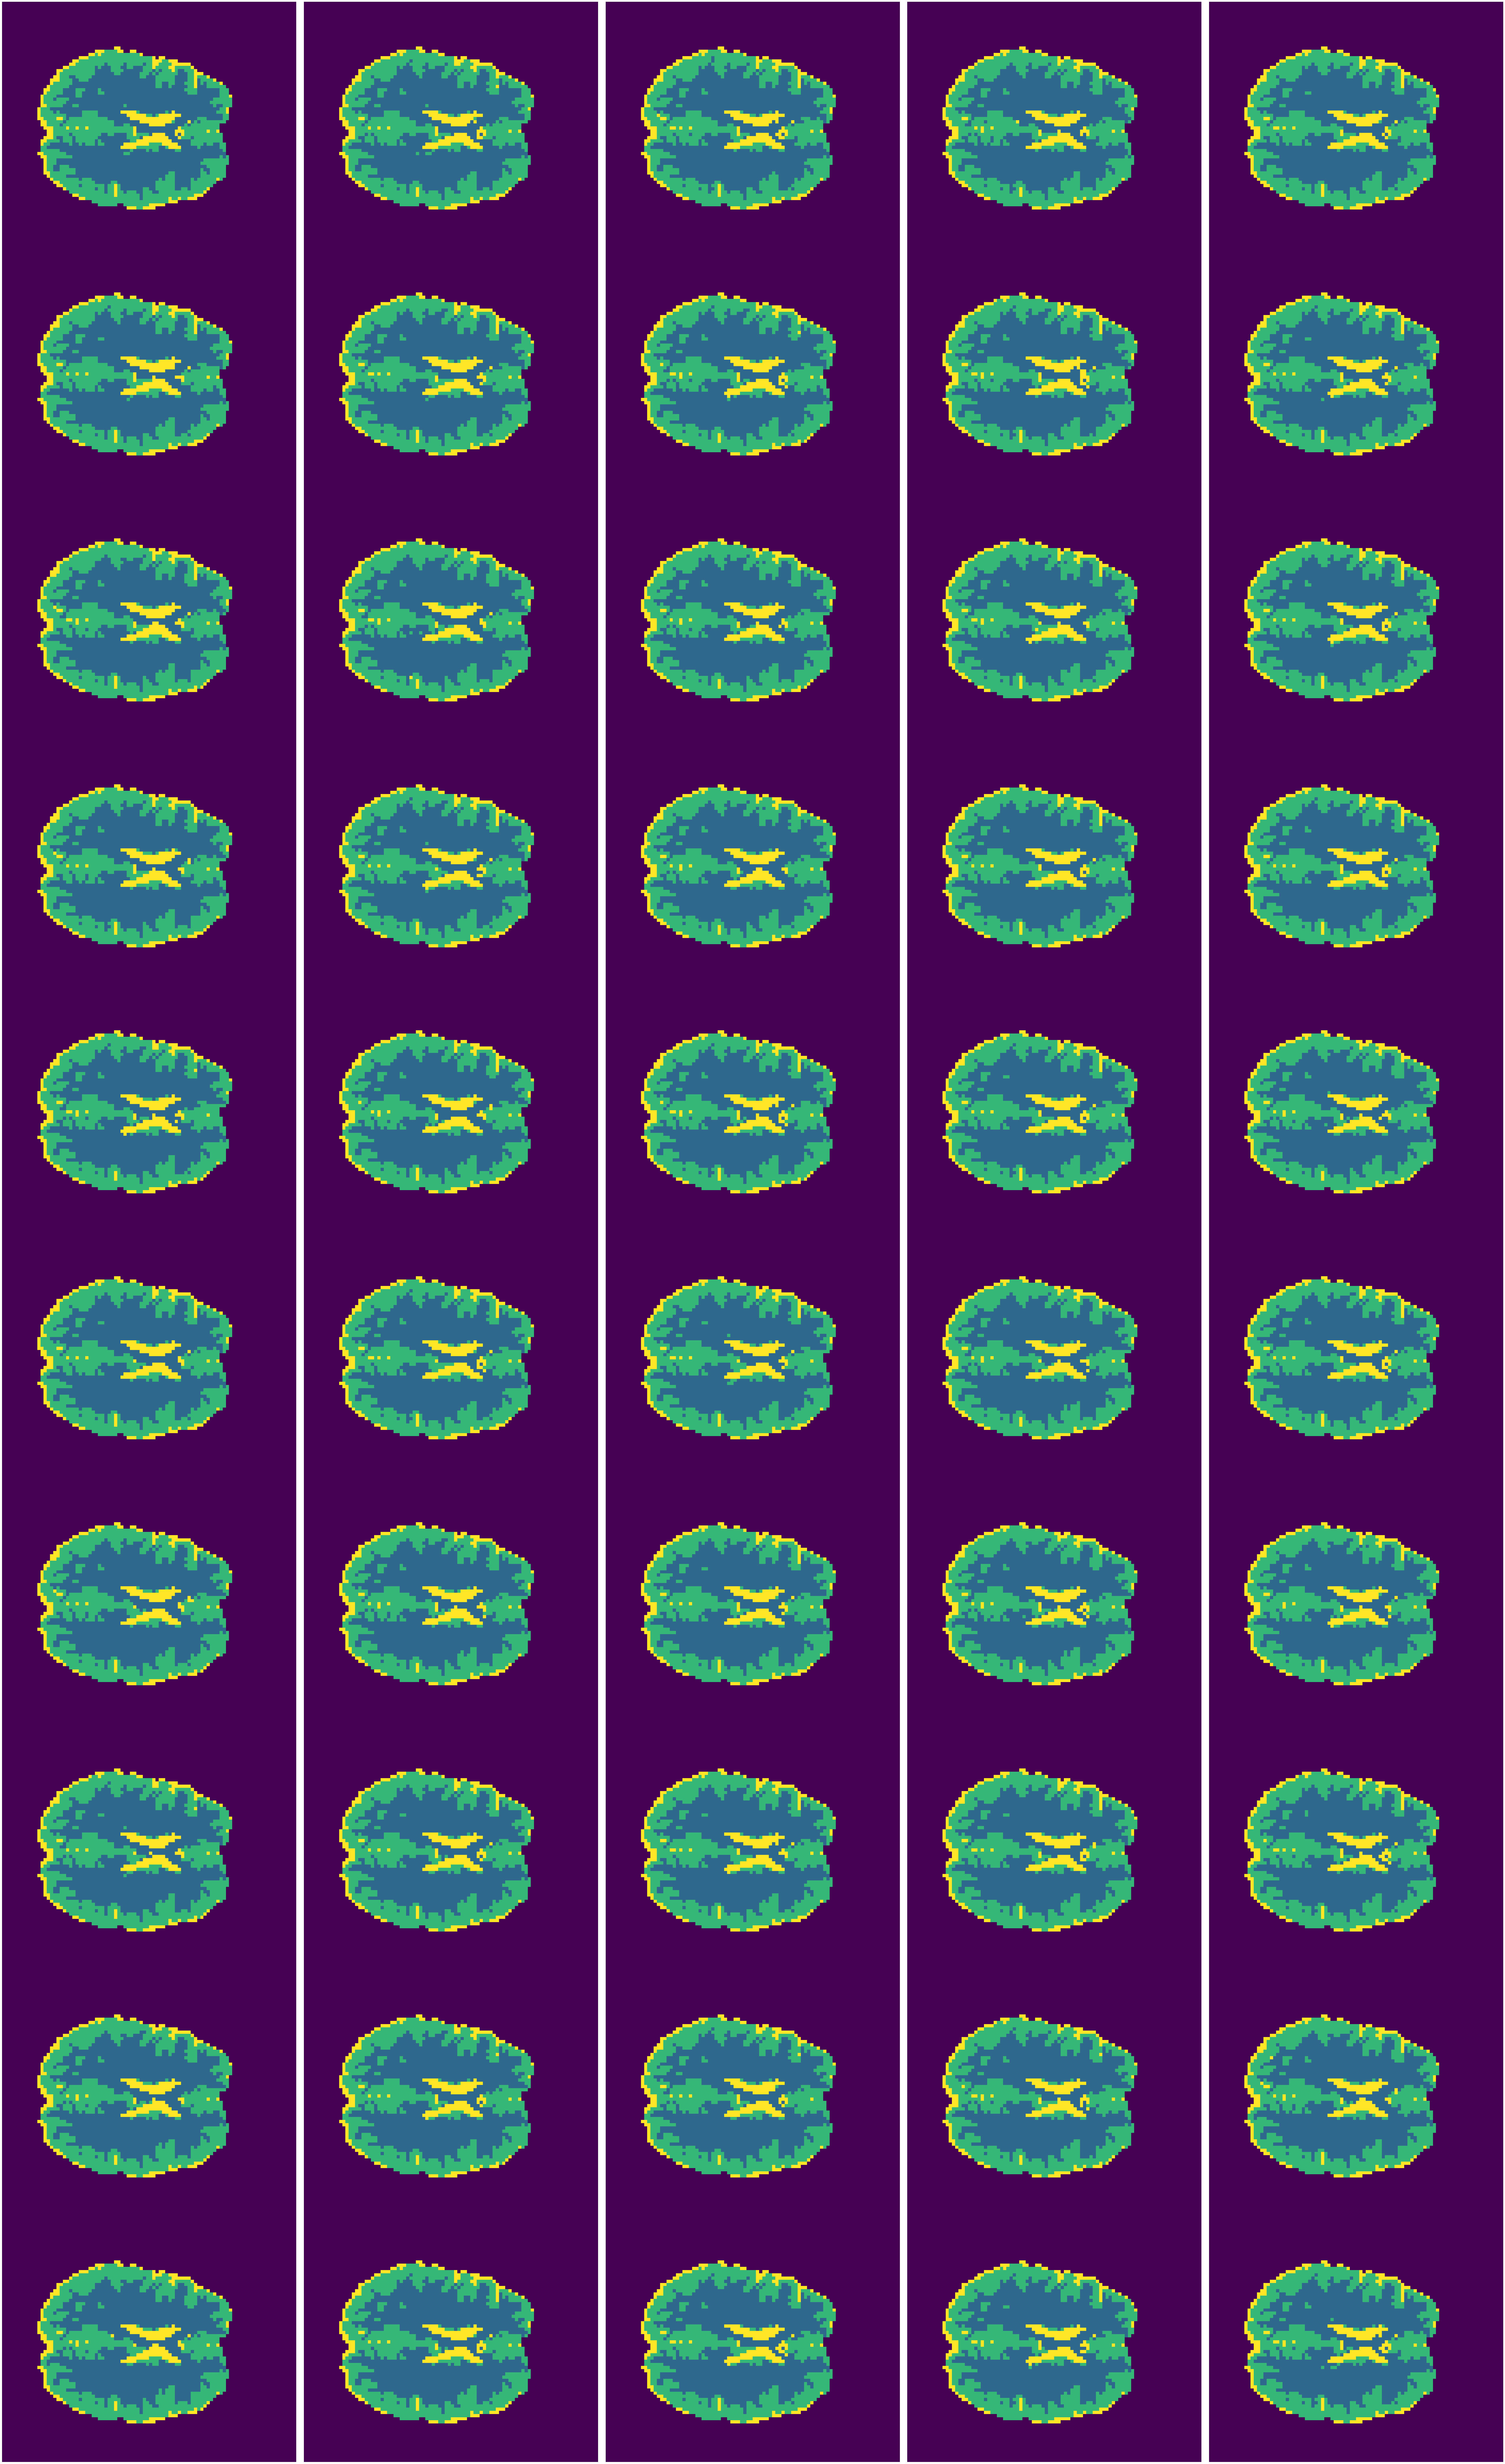

In [32]:
plt.figure(figsize=(92,77*2))
gs1 = gridspec.GridSpec(10, 5, wspace=0.0, hspace=0.0)

for i in range (0,50): 
        plt.subplot(gs1[i])
        plt.imshow(class_S1[:,:,33,i])
        plt.axis('off')
        
plt.savefig("Classifications_86p.png", bbox_inches=0)